In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
use_gpu = True
on_google_colab = False

In [0]:
from zipfile import ZipFile
if on_google_colab:
    fn = 'data.zip'

    with ZipFile(fn,'r') as zip:
      zip.extractall()

In [0]:
from models import U_Net
u_net = U_Net()
if use_gpu:
    u_net = U_Net().cuda()

In [0]:
from DataSetClass import RetinaDataset 
tr = torch.utils.data.DataLoader(RetinaDataset('data/training/','data/manual/'), batch_size=8, shuffle=True)
val = torch.utils.data.DataLoader(RetinaDataset('data/validation/','data/validation_manual/'), batch_size=8, shuffle=True)

In [5]:
def get_accuracy():
    y_true, y_pred  = [], []
    with torch.no_grad():
        for i,data in enumerate(val):
            x, y = data
            if use_gpu:
                x, y = x.cuda(), y.cuda()
            # ground truth
            y = list(np.round(y.cpu().numpy()))
            y_true += y
#             print(y)

            pred = u_net(x)
            # predicted label
            pred = list(np.round(pred.cpu().numpy()))
            y_pred += pred
#             print(pred)
#             break
        
    # calculating overall accuracy
    num_correct = 0
    num_pix = np.shape(y_true[0])[0]*np.shape(y_true[0])[1]*np.shape(y_true[0])[2]
    for i in range(len(y_true)):
        num_correct += np.sum(y_pred[i]==y_true[i])

    acc = num_correct/(len(y_true)*num_pix)
    print("Accuracy: ", acc)
    return acc

get_accuracy()

Accuracy:  0.364038340250651


0.364038340250651

In [0]:
import torch.optim as optim

optimizer = optim.Adam(u_net.parameters())
# criterion = F.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.functional.mse_loss

In [7]:
loss_history = []
acc_history = []
for epoch in range(50):
    train_loss = 0.0
    for i,data in enumerate(tr):
        x, y = data
        if use_gpu:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_pred = u_net(x)
        loss = criterion(y_pred, y)
        x = loss.item()
        train_loss += x
        if (i%40==0):
            print('(%d, %5d) item-loss: %.9f'%(epoch + 1, i + 1, x))
        loss.backward()
        optimizer.step()   
    print('[%d] epoch-loss: %.9f'%(epoch + 1, train_loss))
    loss_history.append(train_loss)
    acc_history.append(get_accuracy())
print('Finished Training')

(1,     1) item-loss: 0.289149195
(1,    41) item-loss: 0.160494208
[1] epoch-loss: 9.677294105
Accuracy:  0.8625740051269531
(2,     1) item-loss: 0.149321511
(2,    41) item-loss: 0.125286266
[2] epoch-loss: 6.520832099
Accuracy:  0.8652745564778646
(3,     1) item-loss: 0.125295252
(3,    41) item-loss: 0.122108847
[3] epoch-loss: 5.583803430
Accuracy:  0.8655794779459636
(4,     1) item-loss: 0.107488133
(4,    41) item-loss: 0.105463766
[4] epoch-loss: 5.158403531
Accuracy:  0.8862335205078125
(5,     1) item-loss: 0.100706369
(5,    41) item-loss: 0.078267023
[5] epoch-loss: 4.911119804
Accuracy:  0.8945101420084636
(6,     1) item-loss: 0.096288770
(6,    41) item-loss: 0.078145668
[6] epoch-loss: 4.722170055
Accuracy:  0.9023661295572917
(7,     1) item-loss: 0.080545612
(7,    41) item-loss: 0.094477214
[7] epoch-loss: 4.616478771
Accuracy:  0.899408467610677
(8,     1) item-loss: 0.085665926
(8,    41) item-loss: 0.091836862
[8] epoch-loss: 4.511984430
Accuracy:  0.9062512715

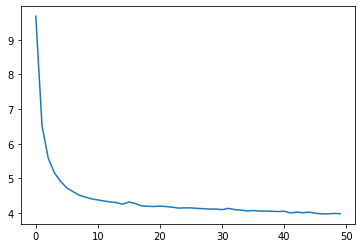

In [8]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

[0.8625740051269531, 0.8652745564778646, 0.8655794779459636, 0.8862335205078125, 0.8945101420084636, 0.9023661295572917, 0.899408467610677, 0.9062512715657552, 0.9117663065592448, 0.9089589436848958, 0.9113038380940756, 0.9103673299153646, 0.9147295633951823, 0.9141705830891927, 0.9155507405598958, 0.9160896301269531, 0.9165918986002605, 0.9116663614908854, 0.917340087890625, 0.9181259155273438, 0.9166638692220052, 0.9164464314778645, 0.9167928059895833, 0.918994140625, 0.9181068420410157, 0.9218416849772135, 0.9184346516927083, 0.9199902852376302, 0.919976552327474, 0.9218513488769531, 0.9209493001302084, 0.9234578450520833, 0.9238858540852865, 0.9200304667154948, 0.923687489827474, 0.9216255187988281, 0.921612803141276, 0.9248146057128906, 0.9241783142089843, 0.925909423828125, 0.9223505655924479, 0.923992411295573, 0.9241477966308593, 0.9224000295003255, 0.9226030985514323, 0.927227274576823, 0.925164794921875, 0.9232065836588542, 0.9254951477050781, 0.9277455647786458]


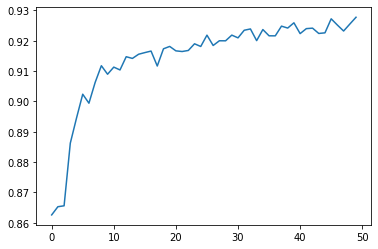

In [9]:
import matplotlib.pyplot as plt
plt.plot(acc_history)
# print(acc_history)

In [10]:
##saving the model
PATH = 'retina_unet_256_16_.pth'
torch.save(u_net.state_dict(), PATH)
##loading the model
model = U_Net()
model.load_state_dict(torch.load(PATH))
model.eval()

U_Net(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (max_pool1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Dropout2d(p=0.5, inplace=False)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (max_pool2): Sequential(
    (0): MaxPool2d(kernel_size

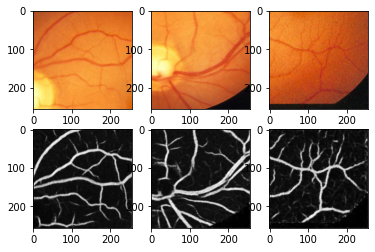

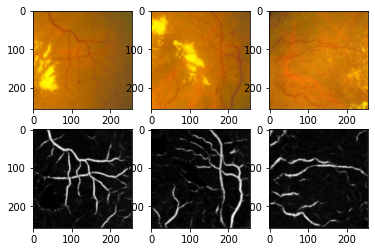

In [11]:
#Showing 2 random segmentations
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

for i in range(2):
    idx = np.random.randint(100)
    im1 = Image.open('data/training/' + str(idx)  + '_orig.jpg')
    im2 = Image.open('data/training/' + str(idx)  + '_rot.jpg')
    im3 = Image.open('data/training/' + str(idx)  + '_noise.jpg')

    s1 = torchvision.transforms.ToTensor()(im1).unsqueeze(0)
    s2 = torchvision.transforms.ToTensor()(im2).unsqueeze(0)
    s3 = torchvision.transforms.ToTensor()(im3).unsqueeze(0)

    pred1 = model(s1).cpu().detach().numpy()
    pred2 = model(s2).cpu().detach().numpy()
    pred3 = model(s3).cpu().detach().numpy()

    f = plt.figure()
    f.add_subplot(2,3, 1)
    plt.imshow(im1)
    f.add_subplot(2,3, 2)
    plt.imshow(im2)
    f.add_subplot(2,3, 3)
    plt.imshow(im3)
    f.add_subplot(2,3, 4)
    plt.imshow(pred1[0][0],cmap='gray')
    f.add_subplot(2,3, 5)
    plt.imshow(pred2[0][0],cmap='gray')
    f.add_subplot(2,3, 6)
    plt.imshow(pred3[0][0],cmap='gray')

[link text](https://)# Results on Validation Data

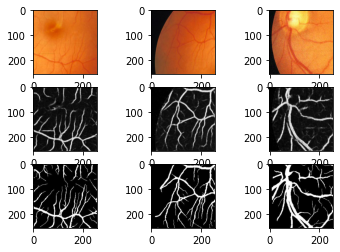

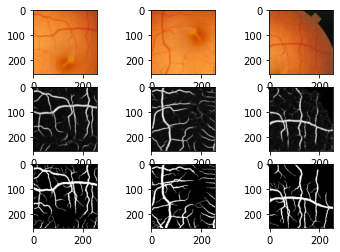

In [14]:
#Showing 2 random segmentations
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

imgs_folder = 'data/validation/'
lbl_folder = 'data/validation_manual/'

for i in range(2):
    idx = np.random.randint(20)
    im1 = Image.open(imgs_folder + str(idx)  + '_orig.jpg')
    im2 = Image.open(imgs_folder + str(idx)  + '_rot.jpg')
    im3 = Image.open(imgs_folder + str(idx)  + '_noise.jpg')
    im4 = Image.open(lbl_folder + str(idx)  + '_orig.jpg')
    im5 = Image.open(lbl_folder + str(idx)  + '_rot.jpg')
    im6 = Image.open(lbl_folder + str(idx)  + '_noise.jpg')

    s1 = torchvision.transforms.ToTensor()(im1).unsqueeze(0)
    s2 = torchvision.transforms.ToTensor()(im2).unsqueeze(0)
    s3 = torchvision.transforms.ToTensor()(im3).unsqueeze(0)

    pred1 = model(s1).cpu().detach().numpy()
    pred2 = model(s2).cpu().detach().numpy()
    pred3 = model(s3).cpu().detach().numpy()

    f = plt.figure()
    f.add_subplot(3,3, 1)
    plt.imshow(im1)
    f.add_subplot(3,3, 2)
    plt.imshow(im2)
    f.add_subplot(3,3, 3)
    plt.imshow(im3)
    f.add_subplot(3,3, 4)
    plt.imshow(pred1[0][0],cmap='gray')
    f.add_subplot(3,3, 5)
    plt.imshow(pred2[0][0],cmap='gray')
    f.add_subplot(3,3, 6)
    plt.imshow(pred3[0][0],cmap='gray')
    f.add_subplot(3,3, 7)
    plt.imshow(im4,cmap='gray')
    f.add_subplot(3,3, 8)
    plt.imshow(im5,cmap='gray')
    f.add_subplot(3,3, 9)
    plt.imshow(im6,cmap='gray')